In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification

In [ ]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [ ]:
df.head()

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
labels = df[1].values

X_train, X_test, y_train, y_test = train_test_split(df[0], labels, random_state=42)

In [ ]:
def encode(data, tokenizer):
  input_ids = []
  attention_masks = []
  token_type_ids = []

  for text in data:
      tokenized_text = tokenizer.encode_plus(text,
                                          max_length=50,
                                          add_special_tokens = True,
                                          pad_to_max_length=True,
                                          return_attention_mask=True,
                                          truncation=True)
      
      input_ids.append(tokenized_text['input_ids'])
      attention_masks.append(tokenized_text['attention_mask'])
      token_type_ids.append(tokenized_text['token_type_ids'])

  return input_ids, attention_masks, token_type_ids

In [ ]:
train_input_ids, train_attention_masks, train_token_type_ids = encode(X_train, tokenizer)
test_input_ids, test_attention_masks, test_token_type_ids = encode(X_test, tokenizer)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
      }, label
      
def data_encode(input_ids_list, attention_mask_list, token_type_ids_list, label_list):
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [ ]:
BATCH_SIZE = 32

train_data_encoded = data_encode(train_input_ids, train_attention_masks, train_token_type_ids,y_train).shuffle(10000).batch(BATCH_SIZE)

test_data_encoded = data_encode(test_input_ids, test_attention_masks, test_token_type_ids, y_test).batch(BATCH_SIZE)

In [ ]:
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2
)

optimizer = tf.keras.optimizers.Adam(1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
NUM_EPOCHS = 10
history = model.fit(train_data_encoded, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=test_data_encoded)

Epoch 1/10
163/163 [==============================] - 131s 445ms/step - loss: 0.4256 - accuracy: 0.8091 - val_loss: 0.2594 - val_accuracy: 0.8971
Epoch 2/10
163/163 [==============================] - 63s 386ms/step - loss: 0.2184 - accuracy: 0.9212 - val_loss: 0.2491 - val_accuracy: 0.8994
Epoch 3/10
163/163 [==============================] - 62s 382ms/step - loss: 0.1342 - accuracy: 0.9568 - val_loss: 0.2602 - val_accuracy: 0.9081
Epoch 4/10
163/163 [==============================] - 62s 381ms/step - loss: 0.0866 - accuracy: 0.9738 - val_loss: 0.2894 - val_accuracy: 0.9023
Epoch 5/10
163/163 [==============================] - 58s 357ms/step - loss: 0.0569 - accuracy: 0.9842 - val_loss: 0.3338 - val_accuracy: 0.9035
Epoch 6/10
163/163 [==============================] - 57s 351ms/step - loss: 0.0311 - accuracy: 0.9927 - val_loss: 0.3563 - val_accuracy: 0.9069
Epoch 7/10
163/163 [==============================] - 62s 382ms/step - loss: 0.0247 - accuracy: 0.9925 - val_loss: 0.4395 - val_a

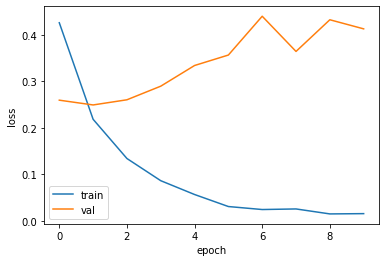

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

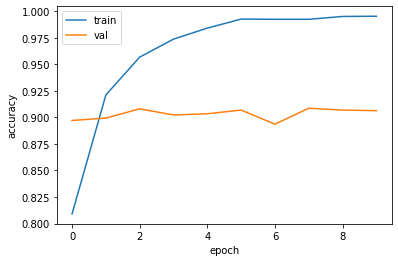

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()